In [1]:
%reload_ext autoreload
%autoreload 2
from code.dataset import Dataset
from code.skipgram import Skipgram

data = '/data/zy/youmi/FDMA/metapath/train/hierarchy'
dataset = Dataset(random_walk_txt=data+'/random_walk_application.txt',\
                  node_type_mapping_txt=data+'/node_type_mapings.txt',\
                  window_size=5,\
                  json_file=data+'/log1/index2nodeid.json',\
                  npz_file=data+'/log1/node_embeddings.npz')

The number of unique words:358857
window size 5


In [2]:
import json
import numpy as np
import pandas as pd
def load_data(csvPath, jsonPath, npzPath):
    df = pd.read_csv(csvPath, low_memory=False)
    index2nodeid = json.load(open(jsonPath))
    index2nodeid = {int(k): v for k, v in index2nodeid.items()}
    nodeid2index = {v: int(k) for k, v in index2nodeid.items()}
    node_embedding = np.load(npzPath)['arr_0']
    return df, index2nodeid, nodeid2index, node_embedding

In [ ]:
import tensorflow as tf
skip_params = {
    'VOCAB_SIZE': len(dataset.nodeid2index),
    'EMBED_SIZE': 128,
    'NUM_SAMPLED': 5,
    'LEARNING_RATE': 0.02,
    'BATCH_SIZE': 10000,
    'OPT_ALGO': 'adam',
    'DATASET' :dataset,
    'LOG_DIRECTORY': data+'/log2',
    'MAX_KEEP_MODEL': 100
    }

skipgram = Skipgram(**skip_params)
skipgram._train(100,0)

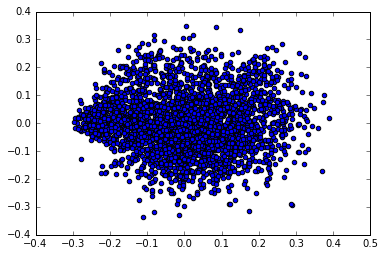

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
df, i2n, n2i, ne = load_data('/data/zy/youmi/FDMA/original_data/clicks_09feb12.csv', \
                             '/data/zy/youmi/FDMA/metapath/train/hierarchy/log2/index2nodeid.json',\
                             '/data/zy/youmi/FDMA/metapath/train/hierarchy/log2/node_embeddings.npz')

partners = df['partnerid'].unique().tolist()
d = []
for cc in partners:
    d.append(ne[n2i[cc]].tolist())
    
pca = PCA(n_components=2)
pca.fit(d)
rd = pca.transform(d)
x, y = [rd[i][0] for i in range(len(rd))], [rd[i][1] for i in range(len(rd))]
plt.scatter(x, y)
plt.show()

In [10]:
def embedding2input(node_embeddings, nodeid2index, fraud, observation, OK, up):
    pos_data = []
    d = []
    for cc in fraud:
        try:
            pos_data.append(node_embeddings[nodeid2index[cc]].tolist() + [1])
            d.append(node_embeddings[nodeid2index[cc]].tolist() + [1, cc])
        except KeyError:
            print cc
    print 'positive data finished!'
    if up:
        # random up-sampling
        tmp = []
        for i in range(10*len(fraud)):
            tmp.append(np.random.randint(0,len(fraud)-1))
        bp_data = [pos_data[i] for i in tmp]
        pos_data = bp_data
    pos_data = np.array(pos_data)
    print pos_data.shape
    
    mid_data = []
    for cc in observation:
        try:
            mid_data.append(node_embeddings[nodeid2index[cc]].tolist() + [0])
            d.append(node_embeddings[nodeid2index[cc]].tolist() + [0, cc])
        except KeyError:
            print cc
    mid_data = np.array(mid_data)
    print mid_data.shape
    print 'observation data finished!'
    
    neg_data = []
    for cc in OK:
        try:
            neg_data.append(node_embeddings[nodeid2index[cc]].tolist() + [-1])
            d.append(node_embeddings[nodeid2index[cc]].tolist() + [-1, cc])
        except KeyError:
            print cc
    neg_data = np.array(neg_data)
    print neg_data.shape
    print 'negative data finished!'
    data = np.concatenate([pos_data, mid_data, neg_data], axis=0)
    print data.shape
    
    sample_ids = np.arange(data.shape[0])
    np.random.shuffle(sample_ids)
    x = np.array([data[i][:-1] for i in sample_ids])
    y = np.array([data[i][-1] for i in sample_ids])
    return x, y

positive data finished!
(72, 129)
(80, 129)
observation data finished!
(2929, 129)
negative data finished!
(3081, 129)


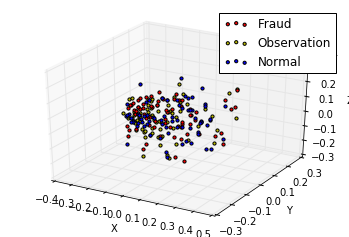

In [42]:
df2 = pd.read_csv('/data/zy/youmi/FDMA/original_data/publishers_09feb12.csv', low_memory=False)
fraud_p = df2[df2['status']=='Fraud']['partnerid'].unique().tolist()
observation_p = df2[df2['status']=='Observation']['partnerid'].unique().tolist()
normal_p = df2[df2['status']=='OK']['partnerid'].unique().tolist()

x, y = embedding2input(ne, n2i, fraud_p, observation_p, normal_p, False)

pca_3d = PCA(n_components=3)
pca_3d.fit(x)
rx = pca_3d.transform(x)
fraud_v, obser_v, normal_v = rx[y==1], rx[y==0], rx[y==-1]

def get_axis_value(v):
    x, y, z = [], [], []
    for i in range(len(fraud_v)):
        x.append(v[i][0])
        y.append(v[i][1])
        z.append(v[i][2])
    return x, y, z

fraud_x, fraud_y, fraud_z = get_axis_value(fraud_v)
obser_x, obser_y, obser_z = get_axis_value(obser_v)
normal_x, normal_y, normal_z = get_axis_value(normal_v)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fraud_x, fraud_y, fraud_z, c='r', depthshade=False, s=10, label='Fraud')
ax.scatter(obser_x, obser_y, obser_z, c='y', depthshade=False, s=10, label='Observation')
ax.scatter(normal_x, normal_y, normal_z, s=10, depthshade=False, label='Normal')
# plt.scatter([normal_x[i][0] for i in range(len(normal_x))], [normal_x[i][1] for i in range(len(normal_x))], \
#             s=10, label='OK')
ax.legend(loc='best')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('/data/zy/youmi/FDMA/metapath/train/hierarchy/pca_3d.png', dpi=300)
plt.show()

In [33]:
obser_v

array([[ 0.21522375,  0.02744111],
       [-0.10466546,  0.11116208],
       [-0.08117268, -0.12271552],
       [ 0.01442234,  0.02588523],
       [ 0.05767519,  0.0366699 ],
       [ 0.06360725, -0.06177722],
       [-0.09167366, -0.03218754],
       [ 0.16928727,  0.01790762],
       [-0.01480032, -0.15840923],
       [-0.20466577,  0.02050292],
       [ 0.24820025,  0.15629483],
       [ 0.14766491,  0.04883578],
       [-0.19890973, -0.01952147],
       [ 0.19667514, -0.01598847],
       [ 0.06331301, -0.02992261],
       [ 0.22277498,  0.18797815],
       [-0.0966695 ,  0.00471815],
       [-0.15632151, -0.02814713],
       [-0.05074217,  0.13016043],
       [-0.25842421,  0.01556255],
       [-0.15891243, -0.01535558],
       [-0.20965042, -0.00365952],
       [ 0.05398046, -0.07842893],
       [ 0.1021821 ,  0.16713985],
       [-0.02152666, -0.01264329],
       [-0.19891505, -0.00878898],
       [ 0.08862848,  0.10548998],
       [ 0.05245245, -0.0272888 ],
       [-0.07765861,

In [26]:
fraud_x

array([[-0.033644  ,  0.00246154],
       [-0.12509451,  0.16761056],
       [-0.04083242, -0.11006003],
       [ 0.17555844,  0.1397396 ],
       [-0.07720756,  0.00749323],
       [ 0.10198505, -0.11066783],
       [-0.16861414,  0.07187727],
       [-0.20715324, -0.04726362],
       [ 0.07355631, -0.00097084],
       [-0.12947476,  0.00098283],
       [-0.06496321,  0.12224442],
       [ 0.1849834 ,  0.23174228],
       [-0.24183606,  0.01015337],
       [-0.12654545,  0.0733739 ],
       [-0.16362556,  0.10427585],
       [-0.1692349 ,  0.00759534],
       [-0.12937309,  0.08994475],
       [-0.08795254, -0.01965274],
       [-0.07836313,  0.15852949],
       [-0.20947107,  0.11225265],
       [-0.0712944 ,  0.10161785],
       [ 0.08811865, -0.03882371],
       [-0.10931875,  0.03895945],
       [-0.13645622,  0.01809988],
       [-0.25017422,  0.04886196],
       [-0.23096269,  0.06958485],
       [-0.22368986,  0.0293008 ],
       [ 0.17127251, -0.01873762],
       [-0.216334  ,